In [2]:
import os
import pandas as pd

In [19]:
data = []
for folder in sorted(os.listdir('doc_dirr')):
    for file in sorted(os.listdir('doc_dirr/'+folder)):
        with open('doc_dirr/'+folder+'/'+file, 'r') as doc:
            content = doc.read().replace('\n', '')
        data.append((folder, file , content))
df = pd.DataFrame(data, columns=['category', 'file_name','content'])
print (df.head())

   category file_name                                            content
0  business   001.txt  Ad sales boost Time Warner profitQuarterly pro...
1  business   002.txt  Dollar gains on Greenspan speechThe dollar has...
2  business   003.txt  Yukos unit buyer faces loan claimThe owners of...
3  business   004.txt  High fuel prices hit BA's profitsBritish Airwa...
4  business   005.txt  Pernod takeover talk lifts DomecqShares in UK ...


In [4]:
df['category_id'] = df['category'].factorize()[0]

In [5]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [6]:
category_id_df

,category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [7]:
category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [8]:
id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [9]:
import matplotlib.pyplot as plt
df.groupby('category').file_name.count().plot.bar(ylim=0)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(2225, 14316)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . bank
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . awards
       . actor
       . film
  . Most correlated bigrams:
       . film festival
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . general election
       . prime minister
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . news website
       . anti virus
       . mobile phone


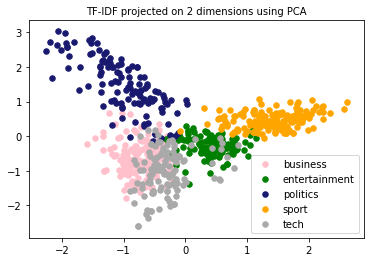

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = pca.fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("TF-IDF projected on 2 dimensions using PCA",
          fontdict=dict(fontsize=10))
plt.legend()

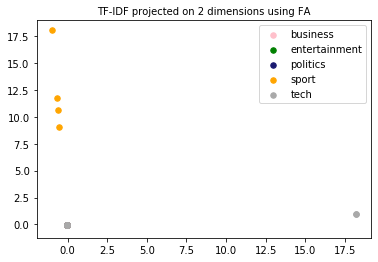

In [13]:
from sklearn.decomposition import FactorAnalysis
pca = PCA(n_components=2, whiten=True)

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = FactorAnalysis(n_components = 2).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("TF-IDF projected on 2 dimensions using FA",
          fontdict=dict(fontsize=10))
plt.legend()

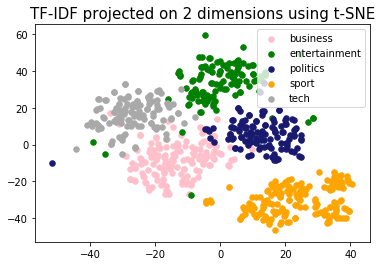

In [20]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("TF-IDF projected on 2 dimensions using t-SNE",
          fontdict=dict(fontsize=15))
plt.legend()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", F

In [1]:
# import seaborn as sns
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df,size=8, jitter=True, edgecolor="gray", linewidth=2)

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.966765
MultinomialNB             0.960461
RandomForestClassifier    0.804988
Name: accuracy, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 15.0, 'Predicted')

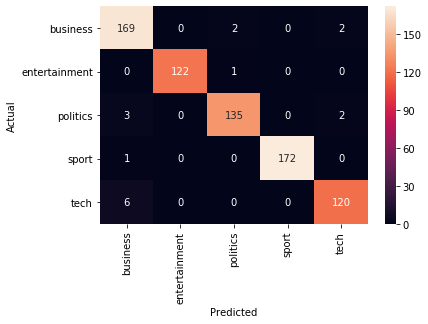

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [35]:
model.fit(features, labels)

C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maduranga.J\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . company
       . bank
       . market
       . firm
       . shares
  . Top bigrams:
       . chief executive
       . stock market
       . analysts said
       . economic growth
       . oil prices
# 'entertainment':
  . Top unigrams:
       . film
       . music
       . singer
       . star
       . band
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . film festival
       . big brother
# 'politics':
  . Top unigrams:
       . labour
       . party
       . mr
       . government
       . election
  . Top bigrams:
       . mr blair
       . prime minister
       . general election
       . mr brown
       . tony blair
# 'sport':
  . Top unigrams:
       . match
       . cup
       . club
       . win
       . game
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . bbc sport
       . world cup
# 'tech':
  . Top unigrams:
       . users
       . computer
       . t

In [38]:
df[df.content.str.lower().str.contains('news website')].category.value_counts()

tech             69
politics          8
entertainment     7
business          1
Name: category, dtype: int64

In [39]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'business'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'

